In [1]:

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


In [2]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [3]:

# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Check that it worked

for c in all_categories[:2]:
    print(c)
    print(category_lines[c])

 'Halabi', 'Nazari', 'Saliba', 'Fakhoury', 'Hadad', 'Baba', 'Mansour', 'Sayegh', 'Antar', 'Deeb', 'Morcos', 'Shalhoub', 'Sarraf', 'Amari', 'Wasem', 'Ganim', 'Tuma', 'Fakhoury', 'Hadad', 'Hakimi', 'Nader', 'Said', 'Ganim', 'Daher', 'Ganem', 'Tuma', 'Boutros', 'Aswad', 'Sarkis', 'Daher', 'Toma', 'Boutros', 'Kanaan', 'Antar', 'Gerges', 'Kouri', 'Maroun', 'Wasem', 'Dagher', 'Naifeh', 'Bishara', 'Ba', 'Cham', 'Kalb', 'Bazzi', 'Bitar', 'Hadad', 'Moghadam', 'Sleiman', 'Shamoun', 'Antar', 'Atiyeh', 'Koury', 'Nahas', 'Kouri', 'Maroun', 'Nassar', 'Sayegh', 'Haik', 'Ghanem', 'Sayegh', 'Salib', 'Cham', 'Bata', 'Touma', 'Antoun', 'Antar', 'Bata', 'Botros', 'Shammas', 'Ganim', 'Sleiman', 'Seif', 'Moghadam', 'Ba', 'Tannous', 'Bazzi', 'Seif', 'Salib', 'Hadad', 'Quraishi', 'Halabi', 'Essa', 'Bahar', 'Kattan', 'Boutros', 'Nahas', 'Sabbagh', 'Kanaan', 'Sayegh', 'Said', 'Botros', 'Najjar', 'Toma', 'Bata', 'Atiyeh', 'Halabi', 'Tannous', 'Kouri', 'Shamoon', 'Kassis', 'Haddad', 'Tuma', 'Mansour', 'Antar', 'K

In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:

import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # A bit more efficient than normal Softmax
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [7]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.9792, -2.9899, -2.8232, -2.9062, -2.8716, -2.9618, -2.8171, -2.8249,
         -2.9135, -2.8950, -2.9442, -2.8325, -2.8694, -2.9348, -2.9252, -2.8337,
         -2.9014, -2.8304]], grad_fn=<LogSoftmaxBackward>)

In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = rnn(input[i], next_hidden)
    print(output)


print(all_categories[torch.argmax(output)])

tensor([[-2.9792, -2.9899, -2.8232, -2.9062, -2.8716, -2.9618, -2.8171, -2.8249,
         -2.9135, -2.8950, -2.9442, -2.8325, -2.8694, -2.9348, -2.9252, -2.8337,
         -2.9014, -2.8304]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9448, -2.9522, -2.7944, -2.8911, -2.8438, -2.8963, -2.8568, -2.8862,
         -2.9615, -2.9200, -2.9043, -2.8427, -2.9384, -2.8956, -2.8713, -2.9822,
         -2.8682, -2.8007]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9438, -2.9940, -2.8535, -2.8641, -2.9546, -2.9009, -2.8213, -2.8699,
         -2.9208, -3.0049, -2.8187, -2.8454, -2.9964, -2.8255, -2.9315, -2.9174,
         -2.9090, -2.7049]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9976, -2.9487, -2.8239, -2.9220, -2.8258, -2.9221, -2.9355, -2.8086,
         -2.9843, -2.9261, -2.7539, -2.9319, -2.8785, -2.8923, -2.8882, -2.9563,
         -2.8088, -2.8608]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9252, -2.9138, -2.8954, -3.0100, -2.8521, -2.9196, -2.8281, -2.9845,
         -2.9974, -2.8951, -2.8070,

In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


## Training

In [18]:

import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Suh
category = Portuguese / line = Rosario
category = Chinese / line = Qiu
category = Japanese / line = Sakata
category = Russian / line = Horos
category = Dutch / line = Peusen
category = Arabic / line = Hadad
category = Spanish / line = Espino
category = Scottish / line = Mitchell
category = Irish / line = O'Meara


In [21]:
# If use softmax -> corss entropy
# If use logsoftmax -> negative log likelihood loss
criterion = nn.NLLLoss()

In [22]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [23]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.3666 Ebina / Japanese ✓
10000 10% (0m 9s) 2.6468 Donoghue / French ✗ (Irish)
15000 15% (0m 13s) 1.7459 Saliba / Arabic ✓
20000 20% (0m 18s) 0.1006 Protopsaltis / Greek ✓
25000 25% (0m 22s) 3.8139 Rhys / Korean ✗ (Irish)
30000 30% (0m 27s) 1.5664 Assen / Dutch ✓
35000 35% (0m 31s) 4.4598 Haas / Arabic ✗ (German)
40000 40% (0m 36s) 1.0251 Beauchene / French ✓
45000 45% (0m 40s) 0.2162 Shadid / Arabic ✓
50000 50% (0m 45s) 0.2473 Rudawski / Polish ✓
55000 55% (0m 49s) 4.0536 Niftrik / Czech ✗ (Dutch)
60000 60% (0m 54s) 1.2999 Abreu / Portuguese ✓
65000 65% (0m 58s) 0.2347 Serafini / Italian ✓
70000 70% (1m 3s) 1.1814 Gomez / Spanish ✓
75000 75% (1m 7s) 0.3228 Ruadhan / Irish ✓
80000 80% (1m 12s) 0.0775 Mclaughlin / Scottish ✓
85000 85% (1m 16s) 1.6662 Mcmahon / Russian ✗ (Irish)
90000 90% (1m 21s) 0.2320 Shim / Korean ✓
95000 95% (1m 25s) 1.2137 Bueren / Dutch ✓
100000 100% (1m 29s) 0.7334 Szwedko / Polish ✓


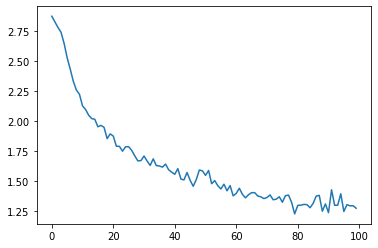

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


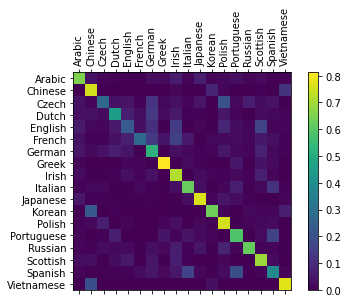

In [42]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [43]:

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.60) Russian
(-1.20) Czech
(-2.72) Polish

> Jackson
(-0.55) Scottish
(-1.41) English
(-2.62) Russian

> Satoshi
(-1.45) Italian
(-1.45) Portuguese
(-1.46) Japanese
